# Projektarbeit Data Analytics

Sebastian Jana,
Sophie Jana

## Inhaltsverzeichnis
<a id ="inhaltsverzeichnis"></a>

[1. Aufgabe](#aufgabe1)

[2. Aufgabe](#aufgabe2)

[3. Aufgabe](#aufgabe3)

4. Aufgabe
5. Aufgabe

[6. Aufgabe](#aufgabe6)

[7. Quellenverzeichnis](#quellenverzeichnis)




### Aufgabe 1 (Datenvorbereitung)
<a id = "aufgabe1"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)

a) Einlesen der CSV Dateien, welche die Stromerzeugungsdaten und die Börsenstrompreise enthalten, als Dataframe df_hourly.

Nach dem ersten Zusammenführen haben wir festgestellt, dass die Datumsspalte je nach CSV-Datei unterschiedliche Namen für Sommerzeit und Winterzeit hat. Dies führt dazu, dass beim Zusammenführen zwei separate Spalten entstehen. Um dies zu vermeiden, prüfen wir bereits beim Einlesen der Dateien die Spaltennamen und führen sie zu einer einheitlichen Spalte „Datum“ im df_hourly zusammen


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Sources for reading csv files from one folder[1],[2]
path = './Daten/Strompreisdaten'
# List all files (.csv) in the given path
csv_files = glob.glob(os.path.join(path, "*csv"))

df_list = []
for i in range(len(csv_files)):
    try:
        df_temp = pd.read_csv(csv_files[i], sep = ",")
        for column in df_temp.columns:
            # Combine the date columns, by getting rid of the naming difference in csv source
            if 'Datum (MESZ)' in column:
                df_temp = df_temp.rename(columns = {'Datum (MESZ)':'DateTime'})
            elif 'Datum (MEZ)' in column:
                df_temp = df_temp.rename(columns = {'Datum (MEZ)':'DateTime'})
        df_list.append(df_temp)
    except Exception as err: 
        print("Fehler beim Einlesen des Files: ", err)
    
df_hourly = pd.concat(df_list)
df_hourly


b) Zur besseren anschließenden Analyse überführen wir die Datumsspalte (vorher dytpe: object) in ein Date-Time-Format. Überprüfung, ob nach der Konvertierung invalide Datumswerte existieren, was nicht der Fall ist.
Alle anderen Spalten haben den dtype float64 und werden so belassen.
Entfernung aller Datensätze, die nicht im Betrachtungszeitraum liegen (2020-2024). Durch Filterung über das Jahr werden 48 Einträge entfernt, da diese nicht in den Betrachtungszeitraum fallen.

In [ ]:
print(df_hourly.shape)
# Converting the column "DateTime" from object to DateTime format
# Invalid values are converted to NaT (Not a Time)
# Source: [3]
df_hourly['DateTime'] = pd.to_datetime(df_hourly['DateTime'], errors="coerce")
print(df_hourly.dtypes)
print(df_hourly['DateTime'].isna().any())


# Create column "Date" from column "DateTime" [4]
df_hourly = df_hourly[(df_hourly['DateTime'].dt.year >= 2020) & (df_hourly['DateTime'].dt.year <= 2024)]

# 48 rows deleted
print(df_hourly.shape) 



c) Beurteilung der Datenqualität und notwenige Datenbereinigungsschritte. 
Qualität der Datumsdaten wurde durch Konvertierung schon überprüft. df_hourly enthält nur Werte für die Jahre 2020-2024. Dataframe enthält keine Null-Werte.

In [ ]:
# Check for missing values
print(df_hourly.isnull().sum())
print(df_hourly.notnull().sum())



d) Erzeugung eines Dataframes df_daily, das für jeden Tag die aggregierten Werte der Leistung der erneuerbaren und nicht erneuerbaren Energiequellen, sowie den täglichen Mittelwert des Börsenpreis enthält. Diese Art der Gruppierung ist sinnvoll für die weitere Analyse, um Trends auf Tagesbasis zu analysieren.

Zur Gruppierung nach Tagen machen wir aus der DateTime nur noch das Datum, indem wir die Uhrzeit entfernen. Anschließend gruppieren wir die Daten nach Datum, wobei die Leistung nicht erneuerbarer und erneuererbarer Energie jeweils für den Tag aufsummiert wird. Zudem gruppieren wir nochmals nach dem Tag und berechnen für jeden Tag den mittleren Börsenpreis. Abschließend joinen wir zu einem gemeinsamen Dataframe df_daily.

In [ ]:
# Grouping by the date without time
# We use a copy to avoid the SettingWithCopyWarning that occurs when we modifiy a view of the original df [5]

df_stunde = df_hourly.copy()

df_stunde['Datum'] = df_stunde['DateTime'].dt.date

df_daily = df_stunde.groupby('Datum')[['Leistung nicht erneuerbar (MW)', 'Leistung erneuerbar (MW)' ]].sum()

df_mean = df_stunde.groupby('Datum')['Day Ahead Auktion Preis (EUR/MWh)'].mean()

df_daily = pd.merge(df_daily, df_mean, on='Datum', how='left').reset_index()

# Change Datum again to datetime format

df_daily['Datum'] = pd.to_datetime(df_daily['Datum'])

df_daily


### Aufgabe 2 (Explorative Analyse der Stromerzeugungs- und Preisdaten)
<a id = "aufgabe2"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)


a) An Welchen 10 Tagen im Betrachtungszeitraum wurden am meisten Strom aus erneuerbaren Energieträgern erzeugt?

Wir beobachten, dass die Tage, an denen der meiste Strom aus erneuererbaren Energieträgern erzeugt wurde, vorwiegend in die Monate Dezember und Februar fallen. 

In [ ]:
ten_highest_days = df_daily.sort_values(by = 'Leistung erneuerbar (MW)', ascending=False).head(10)
ten_highest_days


b) An welchem Tag im Betrachtungszeitraum wurde der höchste Börsenstrompreis verzeichnet und wie hoch war er? (26.08.22)
An welchem Tag im Betrachtungszeitraum wurde der niedrigste Börsenstrompreis verzeichnet und wie hoch war er? (2.7.23)

In [ ]:
highest_price = df_daily['Day Ahead Auktion Preis (EUR/MWh)'].max()
date_highest_price = df_daily[df_daily['Day Ahead Auktion Preis (EUR/MWh)'] == highest_price]

print("Tag mit dem höchsten Börsenstrompreis: " ,date_highest_price['Datum'].dt.date.values[0])
print("Höchster Börsenstrompreis: ", highest_price)

lowest_price = df_daily['Day Ahead Auktion Preis (EUR/MWh)'].min()
date_lowest_price = (df_daily.loc[df_daily['Day Ahead Auktion Preis (EUR/MWh)'] == lowest_price])
print("Tag mit dem niedrigsten Börsenstrompreis: ", date_lowest_price['Datum'].dt.date.values[0])
print("Niedrigster Börsenstrompreis", lowest_price)


c) Wie viele Tage gab es im Betrachtungszeitraum 2020-2024, an denen ein negativer Börsenstrompreis aufgetreten ist?

In [ ]:
negative_price_df = df_daily[df_daily['Day Ahead Auktion Preis (EUR/MWh)'] < 0]
negative_price_day_count = negative_price_df['Day Ahead Auktion Preis (EUR/MWh)'].count()
print("Anzahl der Tage mit einem negativen Börsenstrompreis: ", negative_price_day_count)
negative_price_df


d) Wie viel Strom wurde pro Jahr mit erneuerbaren und mit nicht erneuerbaren Energieträgern erzeugt?

In [ ]:
df_daily['Jahr'] = df_daily['Datum'].astype(str)
df_daily['Jahr'] = df_daily['Jahr'].str[0:4]
df_year = df_daily.groupby('Jahr')[['Leistung nicht erneuerbar (MW)', 'Leistung erneuerbar (MW)']].sum()

#Convert from megawatts (MW) to gigawatts (GW)

df_year['Leistung nicht erneuerbar (GW)'] = (df_year['Leistung nicht erneuerbar (MW)']/1000).round(2)
df_year['Leistung erneuerbar (GW)'] = (df_year['Leistung erneuerbar (MW)']/1000).round(2)
df_year



## Aufgabe 3 (Weiterfürhende Analyse der Stromerzeugung- und Preisdaten)
<a id = "aufgabe3"></a>


[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)


a) Visualisierung der Verteilung der Börsenstrompreise (insgesamt und pro Jahr)

??? Was ist hier mit Verteilung gemeint? evtl Boxplot??


In [ ]:
# "Line chart to show the distribution of prices per day for the observation period

plt.figure(figsize=(15, 6))
plt.plot(df_daily['Datum'], df_daily['Day Ahead Auktion Preis (EUR/MWh)'], label = 'Line', color = 'blue')
plt.xlabel('Betrachtungszeitrum (2020-2024)')
plt.ylabel('mittlerer Börsenstrompreise in € pro Tag')
plt.title('Mittlerer Börsenstrompreis pro Tag für 2020-2024')



Visualisierung der Verteilung der Börsenstrompreise pro Jahr? (evtl dann 4 Linien untereinander?)
->eher mittlerer Werte pro Monat aber dann Wiederholung in b)?
->oder nur die 5 Säulen mit mittlerer Wert pro Jahr?

In [ ]:
import matplotlib.dates as mdates
#Using column Jahr, which contains year as string
# We use a copy to avoid the SettingWithCopyWarning that occurs when we modifiy a view of the original df [5]
year_2020_modified = df_daily[df_daily['Jahr'] == '2020'].copy()
year_2021_modified = df_daily[df_daily['Jahr'] == '2021'].copy()
year_2022_modified = df_daily[df_daily['Jahr'] == '2022'].copy()
year_2023_modified = df_daily[df_daily['Jahr'] == '2023'].copy()
year_2024_modified = df_daily[df_daily['Jahr'] == '2024'].copy()

year_2020_modified['Datum'] = year_2020_modified['Datum'].astype(str)
year_2021_modified['Datum'] = year_2021_modified['Datum'].astype(str)
year_2022_modified['Datum'] = year_2022_modified['Datum'].astype(str)
year_2023_modified['Datum'] = year_2023_modified['Datum'].astype(str)
year_2024_modified['Datum'] = year_2024_modified['Datum'].astype(str)

# ertste Vorkommen von Jahr auf 2000 setzten, um Darstellung auf einer x-Achse zu ermöglichen

year_2020_modified['Datum'] = year_2020_modified['Datum'].str.replace('2020', '2000')
year_2021_modified['Datum'] = year_2021_modified['Datum'].str.replace('2021', '2000')
year_2022_modified['Datum'] = year_2022_modified['Datum'].str.replace('2022', '2000')
year_2023_modified['Datum'] = year_2023_modified['Datum'].str.replace('2023', '2000')
year_2024_modified['Datum'] = year_2024_modified['Datum'].str.replace('2024', '2000')



year_2020_modified['Datum'] = pd.to_datetime(year_2020_modified['Datum'])
year_2021_modified['Datum'] = pd.to_datetime(year_2021_modified['Datum'])
year_2022_modified['Datum'] = pd.to_datetime(year_2022_modified['Datum'])
year_2023_modified['Datum'] = pd.to_datetime(year_2023_modified['Datum'])
year_2024_modified['Datum'] = pd.to_datetime(year_2024_modified['Datum'])

plt.figure(figsize=(15, 10))
plt.plot(year_2020_modified['Datum'], year_2020_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2020', color = 'black')
plt.plot(year_2021_modified['Datum'], year_2021_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2021', color = 'blue')
plt.plot(year_2022_modified['Datum'], year_2022_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2022', color = 'orange')
plt.plot(year_2023_modified['Datum'], year_2023_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2023', color = 'red')
plt.plot(year_2024_modified['Datum'], year_2024_modified['Day Ahead Auktion Preis (EUR/MWh)'], label = '2024', color = 'green')


plt.xlabel("Jahr")
plt.ylabel('mittlerer Börsenstrompreise in € pro Tag')
plt.title('Mittlerer Börsenstrompreis pro Tag pro Jahr')
plt.legend(loc='upper right')


# Source [6] Chat-GPT mit Prompt
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Setzt die Haupt-Ticks auf Monatsanfang
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))  # Zeigt nur den Monat als Zahl (1-12)



b) Berechnung auf die einzelnen Jahre des Betrachtungszeitraum verschiedene statistische Kenngrößen für den Börsenstrompreis

In [ ]:
df_daily['Monat'] = df_daily['Datum'].dt.month
df_year = df_daily.groupby(['Jahr', 'Monat'])['Day Ahead Auktion Preis (EUR/MWh)']

df_year.describe()

# maybe round(2)

c) Visualisierung in einem Säulendiagramm die mittleren Börsenstrompreise pro Monat im Betrachtungszeitraum

In [ ]:
df_year_monthly = df_daily.groupby(['Jahr', 'Monat'])['Day Ahead Auktion Preis (EUR/MWh)'].mean()

df_year_monthly.plot(kind = 'bar', figsize=(15,10))
plt.ylim(0, 500)

plt.title('Mittlerer Börsenstrompreis pro Monat von 2020-2024')
plt.ylabel('Mittlerer Börsenstrompreis in EUR/MWh')


d)

e) Berechnung und Visualisierung der im Mittel mit erneuerbaren Energieträgern erzeugten Energie im Tagesverlauf, indem wir auf die vollen Stunden eines Tages aggregieren. Der df_daily hat als Aggregation für den Tag die Summe der erneuerbaren und nicht erneuerbaren Energie pro Tag. Deswegen gruppieren wir den df_hourly nochmal nach Tagen und nehmen dann für die erneuerbaren Energien den Mittelwert

In [ ]:
# use df_stunde, which contains the transformed "Datum" as date and not datetime
df_renewable_daily=df_stunde.groupby('Datum')['Leistung erneuerbar (MW)'].mean().reset_index()
df_renewable_daily['Leistung erneuerbar (GW)'] = df_renewable_daily['Leistung erneuerbar (MW)']/1000

# Sinnvolle Darstellung??
plt.figure(figsize=(20, 10))

plt.scatter(df_renewable_daily['Datum'], df_renewable_daily['Leistung erneuerbar (MW)'], label = 'scatter', color = 'blue')
plt.title('ashshsh')
plt.show()




### Aufgabe 6 (Analyse von Stromtarif-Angeboten für Endkunden)
<a id = "aufgabe6"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)

a) Führen Sie die gegebenen Preisvergleichdaten in einem DataFrame namens df_cust zusammen. Exportieren Sie diesen als CSV-Datei namens prices_customers.csv und laden Sie diese mit Ihrer Abgabe auf Moodle hoch. Verwerfen Sie bitte zur Minimierung der Dateigröße alle Spalten, die im weiteren Verlauf nicht mehr verwendet werden. Kommentieren Sie nun den Code zur Datensatzgenerierung aus und lesen Sie die CSV-Datei in den DataFrame df_cust erneut aus dieser Datei ein.


In [ ]:
'''
path = './Daten/Endkundenpreise/'

def extract_date_from_filepath(file):
    file = file.replace(path, "")
    # Concatenate the date out of fixed year 2024 and month/day from folder name
    return "2024-" + file[0:5]

def extract_data_from_json(file):
    assert file.endswith(".json"), "Keine json-Datei uebergeben"
    try:
        # Read and load the json file
        df_temp = pd.read_json(json_files[i])
        # Transpose the table: convert the rows to columns
        df_temp = df_temp.T
        # Add date from filename as column
        df_temp['Datum'] = extract_date_from_filepath(file)
        
        return df_temp
    except:
        print("Datei konnte nicht gelesen werden.")

def drop_unnecessary_columns(df):
    columns_to_drop = ['Postleitzahl', 'Jahresverbrauch', 'Abschlagszahlung', 'Verlängerung', 'Kündigungsfrist', 'Grundpreis', 'Arbeitspreis', 'Preisgarantie', 'Grundpreisrabatt:', 'Neukundenbonus', 'Sofortbonus', 'Arbeitspreisrabatt', 'Zusätzlicher Aktionsbonus', 'Blitzbonus', 'Abschlagsrabatt', 'Grundpreisrabatt', 'Winterprämie']
    return df.drop(columns = columns_to_drop)

df_list = []
# https://www.tutorialspoint.com/python/os_listdir.htm
for folder in os.listdir(path):
    combined_path = os.path.join(path, folder, "*json")
    json_files = glob.glob(combined_path)

    for i in range(len(json_files)):
        df_temp = extract_data_from_json(json_files[i])
        df_list.append(df_temp)
        
df_cust = pd.concat(df_list)
df_cust = drop_unnecessary_columns(df_cust)
# https://www.datacamp.com/tutorial/save-as-csv-pandas-dataframe
df_cust.to_csv('prices_customers.csv', index = False, encoding='utf-8')
'''


b) Bereiten Sie die Daten auf die weitere Analyse vor, indem Sie geeignete Datentransformations- und -bereinigungsschritte durchführen.

In [ ]:
df_cust = pd.read_csv('prices_customers.csv')
print("Zeilen vor Bereinigung:", df_cust.shape[0])

df_cust['Datum'] = pd.to_datetime(df_cust['Datum'])

def combine_price_columns(row):
    if pd.isna(row['Preis im 1. Jahr*']):
        return row['Preis im 1. Jahr']
    return row['Preis im 1. Jahr*']

def replace_string_from_row(row, column, string, string_to_replace_with):
    if pd.isna(row[column]):
        return row[column]
    if string in row[column]:
        return row[column].replace(string, string_to_replace_with)
    return row[column]

# Combine the two price columns into one
df_cust['Preis'] = df_cust.apply(combine_price_columns, axis = 1)
df_cust = df_cust.drop(columns = ['Preis im 1. Jahr*', 'Preis im 1. Jahr'])
# Drop rows with NaN as Preis, because those rows aren't viable for a comparison later on
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
df_cust = df_cust.dropna(subset=['Preis'])

df_cust['Vertragslaufzeit'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Vertragslaufzeit', " Monate", ""), axis=1)
df_cust['Vertragslaufzeit'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Vertragslaufzeit', " Monat", ""), axis=1)
# Fill NaN values, so that dtype can be converted to int
df_cust['Vertragslaufzeit'] = df_cust['Vertragslaufzeit'].fillna(0)
df_cust['Vertragslaufzeit'] = df_cust['Vertragslaufzeit'].astype(int)

df_cust['Preis'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Preis', " €/Monat", ""), axis=1)
# Change decimal comma, to decimal point for float conversion
df_cust['Preis'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Preis', ",", "."), axis=1)
df_cust['Preis'] = df_cust['Preis'].astype(float)
df_cust = df_cust.rename(columns = {'Preis' : 'Preis im 1. Jahr/ pro Monat in €', 'Vertragslaufzeit' : 'Vertragslaufzeit in Monaten'})

print("Zeilen nach Bereinigung:", df_cust.shape[0])



c) Wie viele verschiedene Tarife wurden insgesamt angeboten? Zu wie vielen Tagen sind pro Stadt Daten vorhanden? Wie viele verschiedene Anbieter haben insgesamt Tarife angeboten?

In [ ]:
unique_tariffe = df_cust['Tarif'].unique()
print("Anzahl verschiedender Tarife:" , len(unique_tariffe))

# Occuring Städte in the DataSet
number_of_total_cities = len(df_cust['Stadt'].unique())

# Group with any aggregation to get all unique Datum/Stadt combination entries
grouped_date_city = df_cust.groupby(['Datum', 'Stadt']).agg(Count=('Stadt', 'count')).reset_index()
# Group and count how many different Stadt rows there are for each given date
grouped_date = grouped_date_city.groupby( ['Datum'])['Stadt'].count()
# Filter out the dates that don't have an entry for every Stadt of the DataSet
filtered_dates = grouped_date[grouped_date == number_of_total_cities]
print("Daten für alle Städte sind an", len(filtered_dates), "Tagen vorhanden")

unique_anbieter = df_cust['Anbieter'].unique()
print("Anzahl der Anbieter die insgesamt Tarife angeboten haben:", len(unique_anbieter))

d) Ermitteln Sie, welche unterschiedlichen Tarife in Amberg angeboten wurden und visualisieren Sie exemplarisch für die Stadt Amberg den Füllgrad der Daten. Erstellen Sie dazu eine HeatMap, aus der hervorgeht, an welchen Tagen es zu welchen der ermittelten Tarife Angebotsdaten gab.

In [ ]:
df_amberg = df_cust[df_cust['Stadt'] == 'Amberg']

unique_tariffe_amberg = df_amberg['Tarif'].unique()
print("Anzahl verschiedender Tarife:" , len(unique_tariffe_amberg))

plt.figure(figsize=(25, 30))
# HeatMap: green = the Tariff is offered for the given day, none/white = no offering 
plt.scatter(df_amberg['Datum'], df_amberg['Tarif'], color ='green', alpha=0.75)

# https://stackoverflow.com/questions/57796673/switching-month-numbers-to-month-names-on-x-axis-of-histogram-matplotlib
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

plt.xlabel('Datum', fontsize=16) 
plt.ylabel('Tarif', fontsize=16)
plt.title('Verschiedene Tarife für Amberg', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


e) Visualisieren Sie die durchschnittliche Preisentwicklung im Verlauf des Jahres 2024 über alle Tarife und Orte hinweg. Berücksichtigen Sie dabei nur Tarife, bei denen die Vertragslaufzeit mindestens 12 Monate beträgt. Verwenden Sie dazu den Preis im 1. Jahr, der den monatlichen Preis unter Berücksichtigung des Grundpreises, des Arbeitspreises und von Bonuszahlungen o.ä. enthält. Untersuchen Sie anschließend den Zusammenhang zum Börsenstrompreis, indem Sie geeignete Kenngrößen berechnen und weitere Diagramme erstellen.

In [ ]:
filtered_12_months = df_cust[df_cust['Vertragslaufzeit in Monaten'] >= 12]
df_mean_prices = filtered_12_months.groupby(['Datum']).agg(Mean =('Preis im 1. Jahr/ pro Monat in €', 'mean')).reset_index()

plt.figure(figsize=(20, 10))
plt.plot(df_mean_prices['Datum'], df_mean_prices['Mean'], label = 'Line', color = 'red')

#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
# Start y-axis at 0, to not overdramatize the change in consumer price
plt.ylim(bottom = 0, top = 100)

plt.xlabel('Datum', fontsize=16) 
plt.ylabel('Preis pro Monat im 1. Jahr in €', fontsize=16)
plt.title('Durchschnittlicher Endkundenpreis', fontsize=20)

plt.show()

Vergleich Endkundenpreis zu Börsenstrompreis

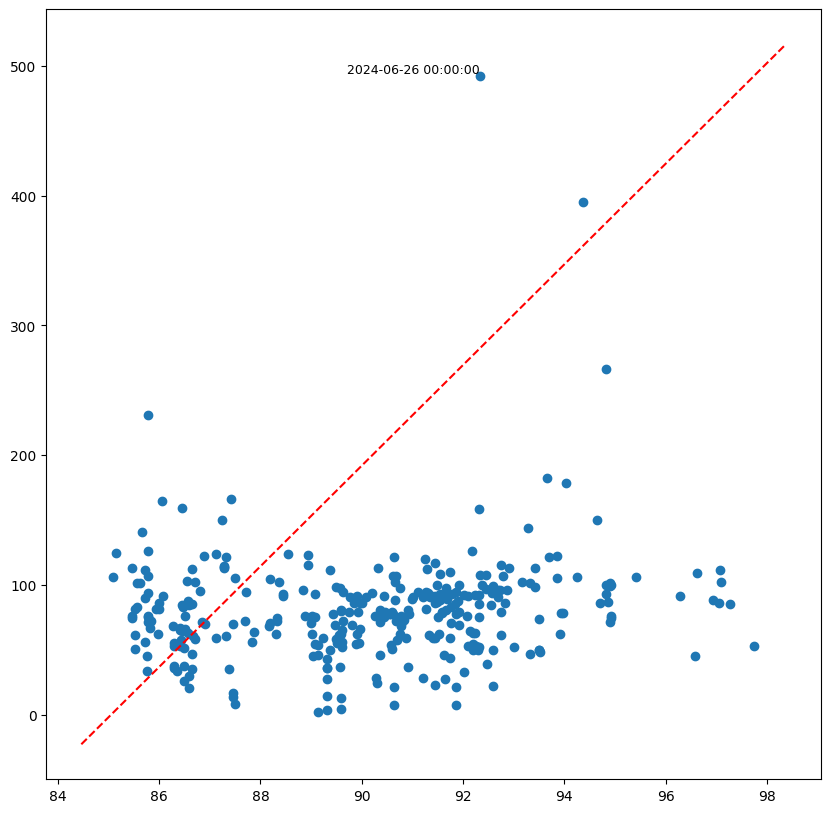

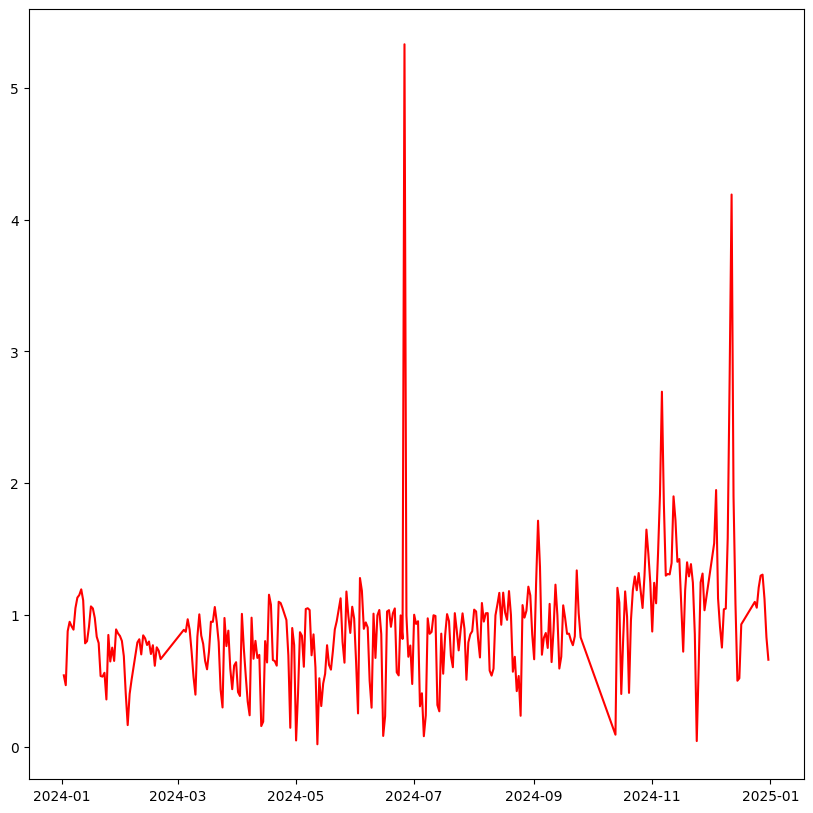

,Datum,Average Consumer Price,Day Ahead Auktion Preis (EUR/MWh),KPI
163,2024-06-26,92.324832,492.035000,5.329390
311,2024-12-12,94.359060,395.338750,4.189728
310,2024-12-11,94.819476,266.544167,2.811070
279,2024-11-06,85.772363,231.091250,2.694239
303,2024-12-04,93.654144,182.469167,1.948330
...,...,...,...,...
152,2024-06-15,91.857862,7.643750,0.083213
173,2024-07-06,90.630017,7.357083,0.081177
107,2024-05-01,89.589421,4.385417,0.048950
297,2024-11-24,89.304968,3.967500,0.044426


In [82]:
df_kunden_boerse = pd.merge(df_mean_prices, df_daily, on = 'Datum', how = 'left', validate='one_to_one')
df_kunden_boerse = df_kunden_boerse.drop(columns = ['Leistung nicht erneuerbar (MW)', 'Leistung erneuerbar (MW)', 'Jahr', 'Monat'])
df_kunden_boerse = df_kunden_boerse.rename(columns = {'Mean':'Average Consumer Price'})
df_kunden_boerse['KPI'] = df_kunden_boerse['Day Ahead Auktion Preis (EUR/MWh)']/ df_kunden_boerse['Average Consumer Price']

plt.figure(figsize=(10, 10))
plt.scatter(df_kunden_boerse['Average Consumer Price'], df_kunden_boerse['Day Ahead Auktion Preis (EUR/MWh)'])
# ChatGPT "How can I add a diagonal line in a matplotlib scatter plot?"
plt.gca().plot(plt.gca().get_xlim(), plt.gca().get_ylim(), color = 'red', linestyle='--')

df_kunden_boerse_sorted = df_kunden_boerse.sort_values(by='KPI', ascending=False)

# Isolate the row with the maximum KPI / first row after sort
df_kunden_boerse_max_row = df_kunden_boerse_sorted.iloc[0]

# Add a text label to the point with the maximum KPI (Best Consumer Price/Exchange Market Price Ratio)
plt.text(df_kunden_boerse_max_row['Average Consumer Price'], 
         df_kunden_boerse_max_row['Day Ahead Auktion Preis (EUR/MWh)'], 
         df_kunden_boerse_max_row['Datum'], 
         fontsize=9, ha='right', va='bottom')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(df_kunden_boerse['Datum'], df_kunden_boerse['KPI'], label = 'Line', color = 'red')
plt.show()

df_kunden_boerse_sorted


i) Im Merkmal Anbieter befinden sich kurze Beschreibungen der Anbieter und der Tarife. Erstellen Sie mit Hilfe des Pakets WordCloud eine Wortwolke für die Anbieter-Beschreibungen und untersuchen Sie, welche Schlagworte besonders häufig auftreten.

In [ ]:
def remove_punctuation_from_anbieter(anbieter):
    punctuations = [".",",","/","&","-","_",":",";"," ,"]
    for p in punctuations:
        anbieter = anbieter.replace(p, "")
    return anbieter
    
def remove_non_buzzwords_from_anbieter(anbieter):
    anbieter_words = anbieter.split() # Isolate each word of Anbieter

    words_to_remove = [
        'der', 'die', 'das', 'und', 'ein', 'eine', 'einen', 'mit', 'ist', 'den', 'dem', 'zu', 'von', 'vom', 
        'auf', 'im', 'an', 'für', 'am', 'als', 'es', 'aber', 'auch', 'aus', 'bei', 'dass', 'um'
        'du', 'er', 'sie', 'wir', 'ihr', 'ihnen', 'ihm', 'euch', 'mir', 'mich', 
        'mein', 'meine', 'dein', 'deine', 'sein', 'seine', 'ihr', 'ihre', 
        'noch', 'schon', 'oder', 'so', 'wie', 'was', 'wer', 'wenn', 'beim'
        'warum', 'weil', 'dann', 'doch', 'nur', 'diese', 'dieser', 'dieses', 
        'jeder', 'jede', 'jedes', 'keiner', 'keine', 'kein', 'welche', 'welcher', 
        'man', 'damit', 'über', 'unter', 'haben', 'hat', 'sein', 'sind', 'war', 'waren', 
        'dabei', 'in', 'seit', 'durch', 'ihren', 'einer', 'sowie'
    ]

    filtered_words = []
    
    for word in anbieter_words:
        # Only keep words that are buzzwords
        if word.lower() not in words_to_remove:
            filtered_words.append(word)

    # https://www.w3schools.com/python/ref_string_join.asp
    return ' '.join(filtered_words)

unique_anbieter_strs = df_cust['Anbieter'].unique()

for i in range(len(unique_anbieter_strs)):
    unique_anbieter_strs[i] = remove_punctuation_from_anbieter(unique_anbieter_strs[i])
    unique_anbieter_strs[i] = remove_non_buzzwords_from_anbieter(unique_anbieter_strs[i])

# Create one String out of all different Anbieter 
combined_text = ' '.join(unique_anbieter_strs)

cloud = WordCloud(background_color='white').generate(combined_text)
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis('off')  # No axes for the word cloud
plt.show()


### Quellenverzeichnis
<a id = "quellenverzeichnis"></a>

[1] https://www.geeksforgeeks.org/how-to-read-all-csv-files-in-a-folder-in-pandas/

[2] https://statistikguru.de/python/python-auflisten-dateien-verzeichnis.html

[3] https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

[4] https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html#pandas.Series.dt.year

[5] https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[6] Chat GPT 

    Prompt (am 05.01.2025): 

    #Using column Jahr, which contains year as string
    # We use a copy to avoid the SettingWithCopyWarning that occurs when we modifiy a view of the original df [5]
    year_2020 = df_daily[df_daily['Jahr'] == '2020'].copy()
    year_2021 = df_daily[df_daily['Jahr'] == '2021'].copy()

    year_2020['Datum'] = year_2020['Datum'].astype(str)
    year_2021['Datum'] = year_2021['Datum'].astype(str)

    # ertste Vorkommen von 2020 auf 2000 setzten

    year_2020['Datum'] = year_2020['Datum'].str.replace('2020', '2000')

    year_2021['Datum'] = year_2021['Datum'].str.replace('2021', '2000')

    year_2020['Datum'] = pd.to_datetime(year_2020['Datum'])
    year_2021['Datum'] = pd.to_datetime(year_2021['Datum'])

    plt.figure(figsize=(12, 6))
    plt.plot(year_2020['Datum'], year_2020['Day Ahead Auktion Preis (EUR/MWh)'], label = '2020', color = 'green')
    plt.plot(year_2021['Datum'], year_2021['Day Ahead Auktion Preis (EUR/MWh)'], label = '2021', color = 'blue')

    Wie kann ich die x-Achse so verändern, dass nicht mehr Jahr-Monat dort steht, sondern nur noch der Monat (also alle Monate von 1-12). Die Darstellung der Tagesdaten soll aber gleich bleiben

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)